# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



# Tasks
The prepared data is after the first part
<input type="checkbox" checked=True> Data Preparation: Data Cleaning and Filter (the final size of sentence is around 67k)
<input type="checkbox" checked=True> RNN-LSTM-GRU three networks: approximate transition probabilities/dataset overfitting
<input type="checkbox"> Optimize the GRU network
<input type="checkbox"> Generated Sentences
<input type="checkbox"> Visualization of word embedding
<input type="checkbox"> Chatbot

## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [1]:
names = {'student_1': "Fengyu Cai",
        'student_2': "Junze Li"}

sciper = {'student_1': 293324, 
          'student_2': 293498}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping


def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [2]:
raw_conversation_train_bothrevised = getRawDataFromFile(datapath="./personachat/", file="train_both_revised.txt")

In [3]:
# training set
print(raw_conversation_train_bothrevised[0])
print('The length of the raw training conversation is %d' % len(raw_conversation_train_bothrevised))

['hi , how are you doing ? i am getting ready to do some cheetah chasing to stay in shape .', 'you must be very fast . hunting is one of my favorite hobbies .', 'i am ! for my hobby i like to do canning or some whittling .', 'i also remodel homes when i am not out bow hunting .', 'that is neat . when i was in high school i placed 6th in 100m dash !', 'that is awesome . do you have a favorite season or time of year ?', 'i do not . but i do have a favorite meat since that is all i eat exclusively .', 'what is your favorite meat to eat ?', 'i would have to say its prime rib . do you have any favorite foods ?', 'i like chicken or macaroni and cheese .', 'do you have anything planned for today ? i think i am going to do some canning .', 'i am going to watch football . what are you canning ?', 'i think i will can some jam . do you also play footfall for fun ?', 'if i have time outside of hunting and remodeling homes . which is not much !']
The length of the raw training conversation is 8938


In [4]:
raw_conversation_test_bothrevised = getRawDataFromFile(datapath="./personachat/", file="test_both_revised.txt")

In [5]:
# test set
print(raw_conversation_test_bothrevised[0])
print('The length of the raw test conversation is %d' % len(raw_conversation_test_bothrevised))

['hello , how are you doing tonight ?', 'i am well an loving this interaction how are you ?', 'i am great . i just got back from the club .', 'this is my favorite time of the year season wise', 'i would rather eat chocolate cake during this season .', 'what club did you go to ? me an timothy watched tv', 'i went to club chino . what show are you watching ?', 'lol oh okay kind of random', 'do you live in a house or apartment ?', 'we watched a show about animals like him', 'i love those shows . i am really craving cake .', 'why does that matter any ? i went outdoors to play frisbee', 'it matters because i have a sweet tooth .', 'so ? lol i want to meet my family at home in bora', 'my family lives in alaska . it is freezing down there .', 'i bet it is oh i could not']
The length of the raw test conversation is 967


We would like to figure out the difference between original and revised dataset. And based on our observation, we find that the original and revised dialogue are actually the same.

In [6]:
raw_conversation_train_bothoriginal = getRawDataFromFile(datapath='./personachat/', file='train_both_original.txt')
print('The length of raw training original conversation is %d' % len(raw_conversation_train_bothoriginal))
print('Are the conversations from original and revised the same? {}'
      .format(raw_conversation_train_bothoriginal == raw_conversation_train_bothrevised))

The length of raw training original conversation is 8938
Are the conversations from original and revised the same? True


### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer**

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer**



**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

In [7]:
def getMergedData(datapath="./personachat/", prefix="train", mode='revised'):
    """
        return the combine data
    """
    listdp= os.listdir(datapath)
    ret_conv = []
    for fn in listdp:
        if fn.startswith(prefix) and fn.endswith(mode + '.txt'):
            ret_conv.extend(getRawDataFromFile(datapath=datapath, file=fn))
    return ret_conv

In [8]:
training_conv = getRawDataFromFile(datapath='personachat/', file='train_both_revised.txt')
test_conv = getRawDataFromFile(datapath='personachat/', file='test_both_revised.txt')
valid_conv = getRawDataFromFile(datapath='personachat/', file='valid_both_revised.txt')

In [9]:
from collections import Counter
def word_occurence(conversations):
    words = []
    for sublist in conversations:
        for sentence in sublist:
            words.extend(sentence.split(' '))
    
    counts = Counter(words)        
    tokens = set(words)
    
    token_occurence = {}
    for i, token in enumerate(tokens):
        token_occurence[token] = counts[token]
    
    return token_occurence    

In [10]:
occ_training_conv = word_occurence(training_conv)
occ_training_conv_sorted = sorted(occ_training_conv.items(), key=lambda item:item[1],reverse = True)
occ_training_conv_top75 = sorted(occ_training_conv.items(), key=lambda item:item[1],reverse = True)[:75]
occ_training_conv_bottom75 = sorted(occ_training_conv.items(), key=lambda item:item[1],reverse = False)[:75]

In [20]:
sum([1 for k,v in occ_training_conv.items() if v >= 50])

1644

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

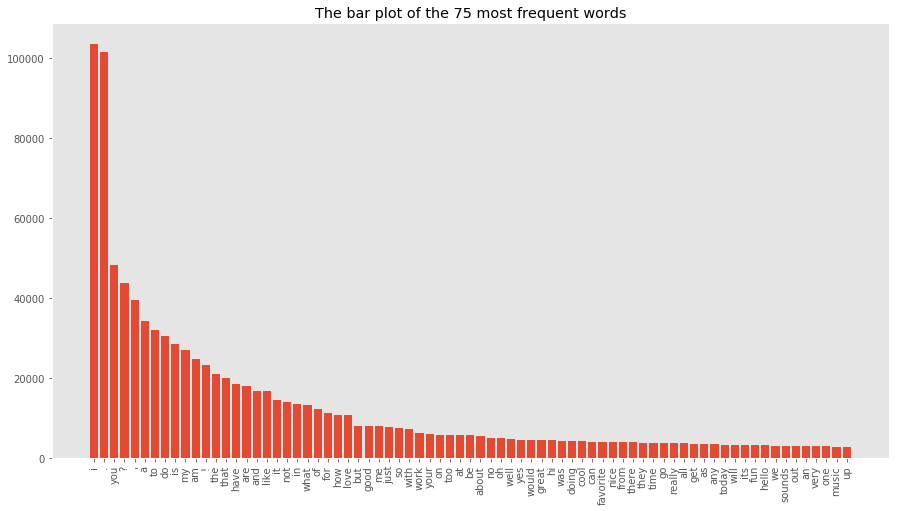

In [11]:
plt.figure(figsize = (15,8))
plt.bar(*zip(*occ_training_conv_top75))
plt.xticks(rotation=90)
plt.title('The bar plot of the 75 most frequent words')
plt.show()

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

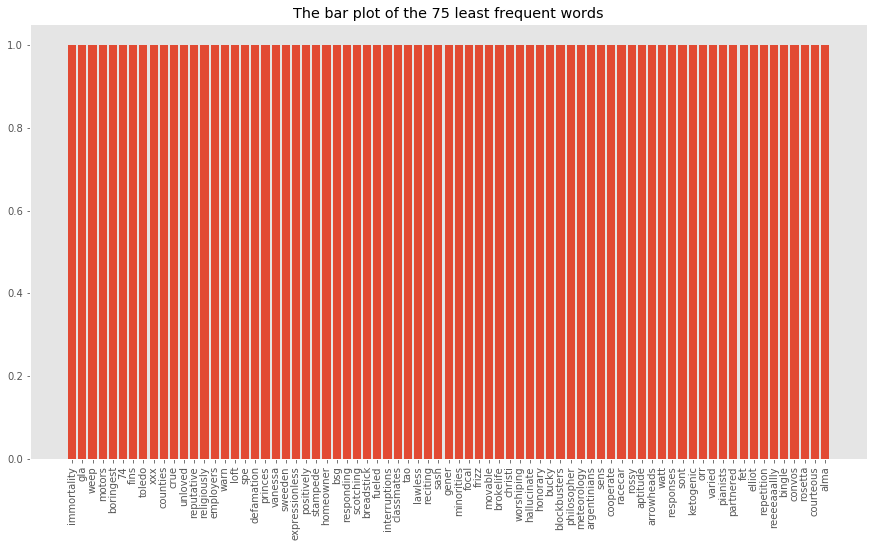

In [12]:
plt.figure(figsize = (15,8))
plt.bar(*zip(*occ_training_conv_bottom75))
plt.xticks(rotation=90)
plt.title('The bar plot of the 75 least frequent words')
plt.show()

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

In [13]:
occ_list = [i[1] for i in occ_training_conv_sorted]

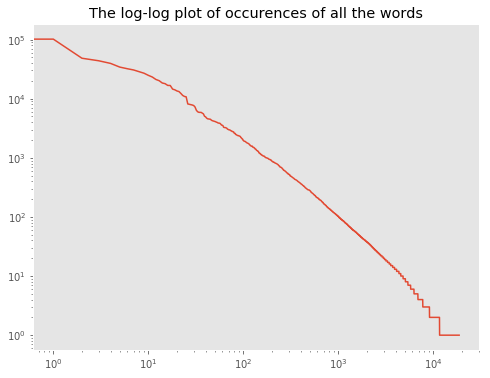

In [14]:
plt.figure(figsize = (8,6))
plt.loglog(occ_list)
plt.title('The log-log plot of occurences of all the words')
plt.show()

In [15]:
once_num = occ_list.count(1)
print('The number of words appear only once is {}.'.format(once_num))

The number of words appear only once is 7080.


**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** The sorted word count can be approximated with a Zipfian distribution (one of a family of discrete power law probability distributions), which is conform to the Zipf's law. 

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** There are 7080 words appearing only once in the entire dataset.

### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: 

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**:

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: 

**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

In [16]:
def conversation_filter(conversations, N):
            
    word_occ = word_occurence(conversations)

    term_list = []
    for key, value in word_occ.items():
        if value < N:
            term_list.append(key)
       
    def judgeKey(line):
        line_split = line.split(' ')
        for term in term_list:
            if term in line_split:
                return False
        return True
    
    filter_conversation = list(filter(judgeKey, [sen for conv in training_conv for sen in conv]))
    
    return filter_conversation

In [21]:
no_word_before_filter = len(occ_training_conv)
print('The number of words before filtering is {}'.format(no_word_before_filter))

The number of words before filtering is 18673


In [22]:
no_word_after_filter = len([k for k,v in occ_training_conv.items() if v>=50])
print('The number of words after filtering is {}'.format(no_word_after_filter))

The number of words after filtering is 1644


In [17]:
sen_before_filter = [sen for conv in training_conv for sen in conv]
print(len(sen_before_filter))

131424


In [16]:
filtered_traininig_conv = conversation_filter(training_conv, 50)

In [24]:
sen_after_filter = [sen for sen in filtered_traininig_conv]
print(len(sen_after_filter))

67024


**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]

**Answer**: After filtering, the number of words has been reduced from 18673 to 1644

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: There are 131424 sentences in original dataset and 67024 sentences in filtered dataset. 

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: It will largely decrease the dimension and computation load, also avoids overfitting to the sentences with rare words.

In [25]:
sen_after_filter

['you must be very fast . hunting is one of my favorite hobbies .',
 'that is awesome . do you have a favorite season or time of year ?',
 'what is your favorite meat to eat ?',
 'hi , how are you doing today ?',
 'i am spending time with my 4 sisters what are you up to',
 'wow , four sisters . just watching game of thrones .',
 'i agree . what do you do for a living ?',
 'that is cool my mom does the same thing',
 'that is awesome . i have always had a love for technology .',
 'tell me more about yourself',
 'i really enjoy free diving , how about you , have any hobbies ?',
 'i enjoy hanging with my mother she is my best friend',
 'that is nice . moms are pretty cool too .',
 'hi ! that is a great line for my next stand up .',
 'lol . i am shy , anything to break the ice , and i am a beatles fan .',
 'i can tell . i am not , you can see me in some tv shows',
 'really ? what shows ? i like tv , it makes me forget i do not like my family',
 'wow , i wish i had a big family . i grew up i

In [26]:
import pickle
with open('filtered_value50.pickle', 'wb') as f:
    pickle.dump(sen_after_filter, f)

In [18]:
# load the sentence after filter
import pickle
with open('filtered_value50.pickle', 'rb') as f:
    sen_after_filter = pickle.loads(f.read())

### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

In [19]:
def transferToInd(sents):
    words = list(set([w for sen in sents for w in sen.split(' ')]))
    words = ['PADD'] + words + ['START', 'END']
    sents_split = [sen.split(' ') for sen in sents]
    
    sents_token = [[words.index(w) for w in ['START'] + sen + ['END']] for sen in sents_split]
    return words, sents_token

In [21]:
# get tokens, the sent_integer sequence
tokens, sent_indseq = transferToInd(sen_after_filter)

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

In [25]:
sent_lens = [len(sen) for sen in sent_indseq]

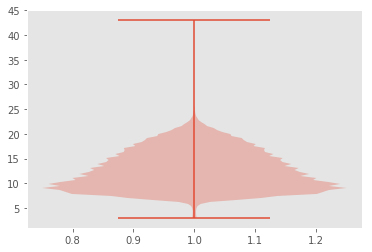

In [26]:
plt.violinplot(sent_lens)
plt.show()

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

In [8]:
maxlen = 23

In [10]:
def paddingAndTruncate(sent_inds):
    sent_padding = keras.preprocessing.sequence.pad_sequences(sequences=sent_inds,
                                                               maxlen=maxlen,
                                                               dtype=np.int,
                                                               padding='post',
                                                               truncating='post',
                                                               value=0)
    return sent_padding

In [24]:
sent_padded = paddingAndTruncate(sent_indseq)

In [25]:
sent_padded

array([[1644,  870, 1343, ...,    0,    0,    0],
       [1644, 1230,  418, ...,    0,    0,    0],
       [1644, 1471,  418, ...,    0,    0,    0],
       ...,
       [1644,  286,  714, ...,    0,    0,    0],
       [1644,  714,  694, ...,    0,    0,    0],
       [1644,  909, 1147, ...,    0,    0,    0]])

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [26]:
def paddedToSent(sent_padded, words, splited=True):
    pos = 1
    sent_recover= []
    while pos < len(sent_padded) and words[sent_padded[pos]] != 'END':
        sent_recover.append(words[sent_padded[pos]])
        pos += 1
    
    if splited:
        return sent_recover
    else:
        return ' '.join(sent_recover)

In [27]:
def paddedsToSents(sents_padded, words, splited=True):
    sents_recover = [paddedToSent(sent, words, splited) for sent in sents_padded]
    return sents_recover

In [30]:
sents_recover = paddedsToSents(sent_padded, tokens, splited=False)
sents_recover[:20]

['you must be very fast . hunting is one of my favorite hobbies .',
 'that is awesome . do you have a favorite season or time of year ?',
 'what is your favorite meat to eat ?',
 'hi , how are you doing today ?',
 'i am spending time with my 4 sisters what are you up to',
 'wow , four sisters . just watching game of thrones .',
 'i agree . what do you do for a living ?',
 'that is cool my mom does the same thing',
 'that is awesome . i have always had a love for technology .',
 'tell me more about yourself',
 'i really enjoy free diving , how about you , have any hobbies ?',
 'i enjoy hanging with my mother she is my best friend',
 'that is nice . moms are pretty cool too .',
 'hi ! that is a great line for my next stand up .',
 'lol . i am shy , anything to break the ice , and i am a beatles fan .',
 'i can tell . i am not , you can see me in some tv shows',
 'really ? what shows ? i like tv , it makes me forget i do not like my family',
 'wow , i wish i had a big family . i grew up i

In [31]:
sen_after_filter[:20]

['you must be very fast . hunting is one of my favorite hobbies .',
 'that is awesome . do you have a favorite season or time of year ?',
 'what is your favorite meat to eat ?',
 'hi , how are you doing today ?',
 'i am spending time with my 4 sisters what are you up to',
 'wow , four sisters . just watching game of thrones .',
 'i agree . what do you do for a living ?',
 'that is cool my mom does the same thing',
 'that is awesome . i have always had a love for technology .',
 'tell me more about yourself',
 'i really enjoy free diving , how about you , have any hobbies ?',
 'i enjoy hanging with my mother she is my best friend',
 'that is nice . moms are pretty cool too .',
 'hi ! that is a great line for my next stand up .',
 'lol . i am shy , anything to break the ice , and i am a beatles fan .',
 'i can tell . i am not , you can see me in some tv shows',
 'really ? what shows ? i like tv , it makes me forget i do not like my family',
 'wow , i wish i had a big family . i grew up i

### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [33]:
import pickle

#save
with open("data.pkl", "wb") as file:
    pickle.dump([sen_after_filter, sent_indseq, sent_padded, tokens], file)

In [6]:
import pickle
#load
with open("data.pkl", "rb") as file:
    [sen_after_filter, sent_indseq, sent_padded, tokens] = pickle.load(file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer**

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer**

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: 

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: 

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: 

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

In [96]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1
readout_size = 256

In [97]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [100]:
from keras.utils import to_categorical
X = sent_padded.astype(np.int)

T = [to_categorical(sen, num_classes=len(tokens)) for sen in X]
T = np.array(T)

### simpleRNN

In [45]:
#Model suggestion
I['RNN'] = Input(shape=(maxlen-1,), name="input")
E['RNN'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")(I['RNN'])

#your network here
H['RNN'] = SimpleRNN(units=hidden_size, return_sequences=True)(E['RNN'])

R['RNN'] = TimeDistributed(Dense(readout_size, activation='relu'))(H['RNN'])
Y['RNN'] = TimeDistributed(Dense(len(words_set), activation='softmax'))(R['RNN'])

models['RNN'] = Model(inputs = [I['RNN']], outputs = [Y['RNN']])
models['RNN'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['RNN'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
# {'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]},
logs['RNN'] = models['RNN'].fit([X[:dataset_cut,:-1]], [T[:dataset_cut,1:]],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['RNN'], file)
models['RNN'].save("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           210688    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 22, 64)            12352     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 22, 100)           6500      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 22, 1646)          166246    
Total params: 395,786
Trainable params: 395,786
Non-trainable params: 0
_________________________________________________________________
(67024, 22) (67024, 22, 1646)
Train on 53618 samples, validate on 13405 samples
Epoch 1/32
53618/53618 [==============================] 

In [5]:
#load
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    RNNmodel_log = pickle.load(file)
RNNmodel = load_model("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

### LSTM

In [46]:
#Model suggestion
I['LSTM'] = Input(shape=(maxlen-1,), name="input")
E['LSTM'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")(I['LSTM'])

#your network here
H['LSTM'] = LSTM(units=hidden_size, return_sequences=True)(E['LSTM'])

R['LSTM'] = TimeDistributed(Dense(readout_size, activation='relu'))(H['LSTM'])
Y['LSTM'] = TimeDistributed(Dense(len(words_set), activation='softmax'))(R['LSTM'])

models['LSTM'] = Model(inputs = [I['LSTM']], outputs = [Y['LSTM']])
models['LSTM'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['LSTM'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
# {'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]},
logs['LSTM'] = models['LSTM'].fit([X[:dataset_cut,:-1]], [T[:dataset_cut,1:]],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['LSTM'], file)
models['LSTM'].save("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           210688    
_________________________________________________________________
lstm_1 (LSTM)                (None, 22, 64)            49408     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 22, 100)           6500      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 22, 1646)          166246    
Total params: 432,842
Trainable params: 432,842
Non-trainable params: 0
_________________________________________________________________
(67024, 22) (67024, 22, 1646)
Train on 53618 samples, validate on 13405 samples
Epoch 1/32
53618/53618 [==============================] 

In [6]:
#load
with open("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    LSTMmodel_log = pickle.load(file)
LSTMmodel = load_model("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size))

### GRU

In [46]:
#Model suggestion
I['GRU'] = Input(shape=(maxlen-1,), name="input")
E['GRU'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")(I['GRU'])

#your network here
H['GRU'] = GRU(units=hidden_size,
               return_sequences=True,
              recurrent_dropout=recurrent_dropout,
              dropout=dropout)(E['GRU'])

R['GRU'] = TimeDistributed(Dense(readout_size, activation='relu'))(H['GRU'])
Y['GRU'] = TimeDistributed(Dense(len(words_set), activation='softmax'))(R['GRU'])

models['GRU'] = Model(inputs = [I['GRU']], outputs = [Y['GRU']])
models['GRU'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
# {'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]},
logs['GRU'] = models['GRU'].fit([X[:dataset_cut,:-1]], [T[:dataset_cut,1:]],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU'], file)
models['GRU'].save("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           210688    
_________________________________________________________________
gru_1 (GRU)                  (None, 22, 64)            37056     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 22, 256)           16640     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 22, 1646)          423022    
Total params: 687,406
Trainable params: 687,406
Non-trainable params: 0
_________________________________________________________________
(67024, 22) (67024, 22, 1646)
Train on 53618 samples, validate on 13405 samples
Epoch 1/32
53618/53618 [==============================] 

In [7]:
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    GRUmodel_log = pickle.load(file)
GRUmodel = load_model("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

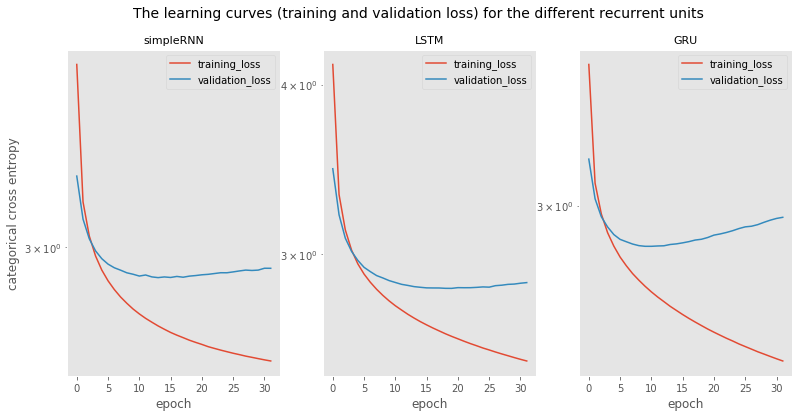

In [79]:
fig, ax = plt.subplots(1,3,figsize=(13,6))
fig.suptitle('The learning curves (training and validation loss) for the different recurrent units',size=14)

ax[0].set_title('simpleRNN',size=11)
ax[0].plot(RNNmodel_log['loss'], label = "training_loss")
ax[0].plot(RNNmodel_log['val_loss'], label = "validation_loss")
ax[0].set_ylabel('categorical cross entropy')
ax[0].set_xlabel('epoch')
ax[0].set_yscale('log')
ax[0].legend()


ax[1].set_title('LSTM',size=11)
ax[1].plot(LSTMmodel_log['loss'], label = "training_loss")
ax[1].plot(LSTMmodel_log['val_loss'], label = "validation_loss")
ax[1].set_xlabel('epoch')
ax[1].set_yscale('log')
ax[1].legend()

ax[2].set_title('GRU',size=11)
ax[2].plot(GRUmodel_log['loss'], label = "training_loss")
ax[2].plot(GRUmodel_log['val_loss'], label = "validation_loss")
ax[2].set_xlabel('epoch')
ax[2].set_yscale('log')
ax[2].legend()
plt.show();

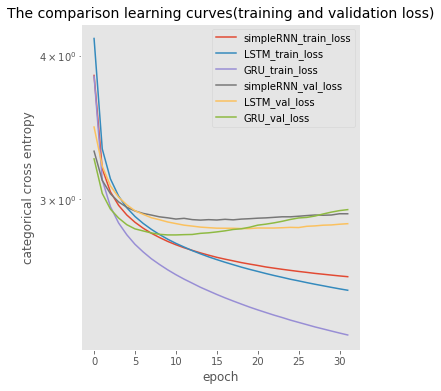

In [87]:
plt.figure(figsize=(5,6))
plt.title('The comparison learning curves(training and validation loss)',size=14)

plt.plot(RNNmodel_log['loss'], label = "simpleRNN_train_loss")
plt.plot(LSTMmodel_log['loss'], label = "LSTM_train_loss")
plt.plot(GRUmodel_log['loss'], label = "GRU_train_loss")
plt.plot(RNNmodel_log['val_loss'], label = "simpleRNN_val_loss")
plt.plot(LSTMmodel_log['val_loss'], label = "LSTM_val_loss")
plt.plot(GRUmodel_log['val_loss'], label = "GRU_val_loss")
plt.ylabel('categorical cross entropy')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show();

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

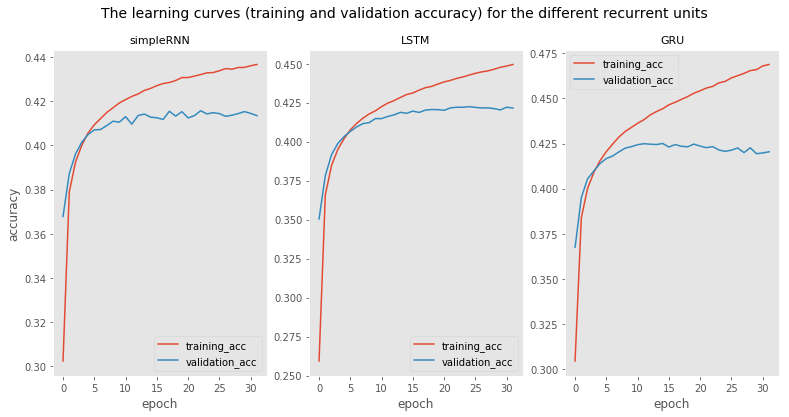

In [88]:
fig, ax = plt.subplots(1,3,figsize=(13,6))
fig.suptitle('The learning curves (training and validation accuracy) for the different recurrent units',size=14)

ax[0].set_title('simpleRNN',size=11)
ax[0].plot(RNNmodel_log['acc'], label = "training_acc")
ax[0].plot(RNNmodel_log['val_acc'], label = "validation_acc")
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()


ax[1].set_title('LSTM',size=11)
ax[1].plot(LSTMmodel_log['acc'], label = "training_acc")
ax[1].plot(LSTMmodel_log['val_acc'], label = "validation_acc")
ax[1].set_xlabel('epoch')
ax[1].legend()

ax[2].set_title('GRU',size=11)
ax[2].plot(GRUmodel_log['acc'], label = "training_acc")
ax[2].plot(GRUmodel_log['val_acc'], label = "validation_acc")
ax[2].set_xlabel('epoch')
ax[2].legend()
plt.show();

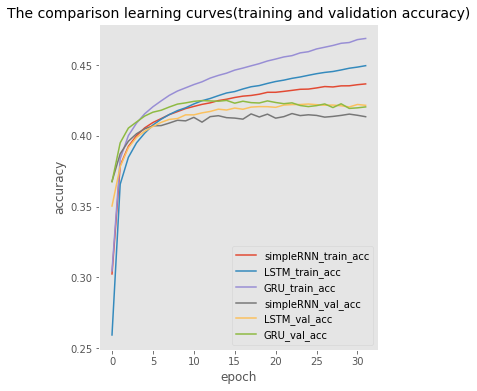

In [90]:
plt.figure(figsize=(5,6))
plt.title('The comparison learning curves(training and validation accuracy)',size=14)

plt.plot(RNNmodel_log['acc'], label = "simpleRNN_train_acc")
plt.plot(LSTMmodel_log['acc'], label = "LSTM_train_acc")
plt.plot(GRUmodel_log['acc'], label = "GRU_train_acc")
plt.plot(RNNmodel_log['val_acc'], label = "simpleRNN_val_acc")
plt.plot(LSTMmodel_log['val_acc'], label = "LSTM_val_acc")
plt.plot(GRUmodel_log['val_acc'], label = "GRU_val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show();

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** 'PADD' will be removed when going through the embedding layer, as the option mark_zero has been set to True.

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer**  The output matrix indicates the probability of each word transferred from the corresponding forward word(s). At each batch, the input is the indexed sentence except the last word, and the output is the probability matrix of the sentence except 'START'. The input tensor dimension is (22,1) and the output tensor dimension is (22,1646). 

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: LSTM and GRU yield the similar best validation accuracy around 42%. GRU is the fastest learner based on the time spent for each epoch.

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: There is an overfitting effect after 10 epoches in GRU recurrent unit. GRU is the fastest learner as indidated in last question, so the overfitting effect of it appears first within the same number of epoches compared to simpleRNN and LSTM.

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: Remove more sentences containing low frequency words.

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: Implement the regularization in each neural, and add dropout layers.

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: Import the method of earlystopping.

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer**

**Question** What is your best model? Why? [1 pt]

**Answer**



In [91]:
embedding_matrix = GRUmodel.get_layer('embedding').get_weights()

In [103]:
earlystopping = EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2)

### Single layer 128-GRU

In [104]:
#Model suggestion
hidden_size = 128
I['GRU_128'] = Input(shape=(maxlen-1,), name="input")
E['GRU_128'] = Embedding(len(tokens),
                     embedding_size,
                     mask_zero=True,
                     name="embedding",
                     weights=[embedding_matrix[0]],
                     trainable=False)(I['GRU_128'])

#your network here
H['GRU_128'] = GRU(units=hidden_size,
               return_sequences=True,
              recurrent_dropout=recurrent_dropout,
              dropout=dropout)(E['GRU_128'])

R['GRU_128'] = TimeDistributed(Dense(readout_size, activation='relu'))(H['GRU_128'])
Y['GRU_128'] = TimeDistributed(Dense(len(tokens), activation='softmax'))(R['GRU_128'])

models['GRU_128'] = Model(inputs = [I['GRU_128']], outputs = [Y['GRU_128']])
models['GRU_128'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU_128'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
# {'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]},
logs['GRU_128'] = models['GRU_128'].fit([X[:dataset_cut,:-1]], [T[:dataset_cut,1:]],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks=[earlystopping]).history

#save
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU_128'], file)
models['GRU_128'].save("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           210688    
_________________________________________________________________
gru_3 (GRU)                  (None, 22, 128)           98688     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 22, 256)           33024     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 22, 1646)          423022    
Total params: 765,422
Trainable params: 554,734
Non-trainable params: 210,688
_________________________________________________________________
(67024, 22) (67024, 22, 1646)
Train on 53618 samples, validate on 13405 samples
Epoch 1/32
53618/53618 [==========================

### Single layer 256-GRU

In [107]:
#Model suggestion
hidden_size = 256
I['GRU_256'] = Input(shape=(maxlen-1,), name="input")
E['GRU_256'] = Embedding(len(tokens),
                     embedding_size,
                     mask_zero=True,
                     name="embedding",
                     weights=[embedding_matrix[0]],
                     trainable=False)(I['GRU_256'])

#your network here
H['GRU_256'] = GRU(units=hidden_size,
               return_sequences=True,
              recurrent_dropout=recurrent_dropout,
              dropout=dropout)(E['GRU_256'])

R['GRU_256'] = TimeDistributed(Dense(readout_size, activation='relu'))(H['GRU_256'])
Y['GRU_256'] = TimeDistributed(Dense(len(tokens), activation='softmax'))(R['GRU_256'])

models['GRU_256'] = Model(inputs = [I['GRU_256']], outputs = [Y['GRU_256']])
models['GRU_256'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU_256'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
# {'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]},
logs['GRU_256'] = models['GRU_256'].fit([X[:dataset_cut,:-1]], [T[:dataset_cut,1:]],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks=[earlystopping]).history

#save
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU_256'], file)
models['GRU_256'].save("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           210688    
_________________________________________________________________
gru_5 (GRU)                  (None, 22, 256)           295680    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 22, 256)           65792     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 22, 1646)          423022    
Total params: 995,182
Trainable params: 784,494
Non-trainable params: 210,688
_________________________________________________________________
(67024, 22) (67024, 22, 1646)
Train on 53618 samples, validate on 13405 samples
Epoch 1/32
53618/53618 [==========================

### Two layers 64-GRU

In [108]:
#Model suggestion
hidden_size = 64
I['GRU_2_64'] = Input(shape=(maxlen-1,), name="input")
E['GRU_2_64'] = Embedding(len(tokens),
                     embedding_size,
                     mask_zero=True,
                     name="embedding",
                     weights=[embedding_matrix[0]],
                     trainable=False)(I['GRU_2_64'])

#your network here
H['GRU_2_64'] = GRU(units=hidden_size,
               return_sequences=True,
              recurrent_dropout=recurrent_dropout,
              dropout=dropout)(E['GRU_2_64'])

H['GRU_2_64'] = GRU(units=hidden_size,
               return_sequences=True,
              recurrent_dropout=recurrent_dropout,
              dropout=dropout)(H['GRU_2_64'])

R['GRU_2_64'] = TimeDistributed(Dense(readout_size, activation='relu'))(H['GRU_2_64'])
Y['GRU_2_64'] = TimeDistributed(Dense(len(tokens), activation='softmax'))(R['GRU_2_64'])

models['GRU_2_64'] = Model(inputs = [I['GRU_2_64']], outputs = [Y['GRU_2_64']])
models['GRU_2_64'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU_2_64'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
# {'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]},
logs['GRU_2_64'] = models['GRU_2_64'].fit([X[:dataset_cut,:-1]], [T[:dataset_cut,1:]],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks=[earlystopping]).history

#save
with open("GRUmodel_"+str(embedding_size)+'_'+'2_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU_2_64'], file)
models['GRU_2_64'].save("GRUmodel_"+str(embedding_size)+'_'+'2_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           210688    
_________________________________________________________________
gru_6 (GRU)                  (None, 22, 64)            37056     
_________________________________________________________________
gru_7 (GRU)                  (None, 22, 64)            24768     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 22, 256)           16640     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 22, 1646)          423022    
Total params: 712,174
Trainable params: 501,486
Non-trainable params: 210,688
________________________________________________________________

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

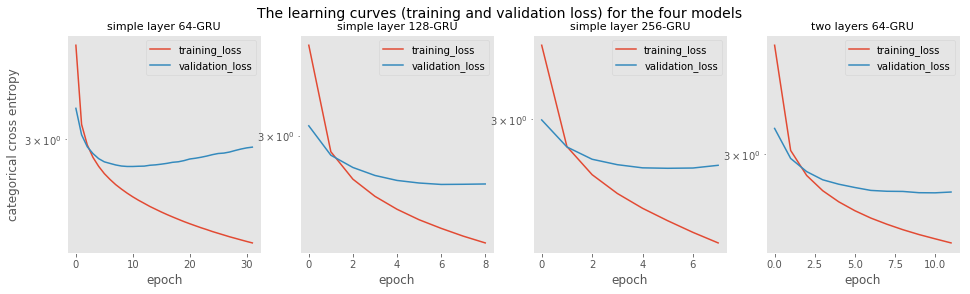

In [147]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
fig.suptitle('The learning curves (training and validation loss) for the four models',size=14)

ax[0].set_title('simple layer 64-GRU',size=11)
ax[0].plot(GRUmodel_log['loss'], label = "training_loss")
ax[0].plot(GRUmodel_log['val_loss'], label = "validation_loss")
ax[0].set_ylabel('categorical cross entropy')
ax[0].set_xlabel('epoch')
ax[0].set_yscale('log')
ax[0].legend()


ax[1].set_title('simple layer 128-GRU',size=11)
ax[1].plot(logs['GRU_128']['loss'], label = "training_loss")
ax[1].plot(logs['GRU_128']['val_loss'], label = "validation_loss")
ax[1].set_xlabel('epoch')
ax[1].set_yscale('log')
ax[1].legend()

ax[2].set_title('simple layer 256-GRU',size=11)
ax[2].plot(logs['GRU_256']['loss'], label = "training_loss")
ax[2].plot(logs['GRU_256']['val_loss'], label = "validation_loss")
ax[2].set_xlabel('epoch')
ax[2].set_yscale('log')
ax[2].legend()

ax[3].set_title('two layers 64-GRU',size=11)
ax[3].plot(logs['GRU_2_64']['loss'], label = "training_loss")
ax[3].plot(logs['GRU_2_64']['val_loss'], label = "validation_loss")
ax[3].set_xlabel('epoch')
ax[3].set_yscale('log')
ax[3].legend()

plt.show();

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

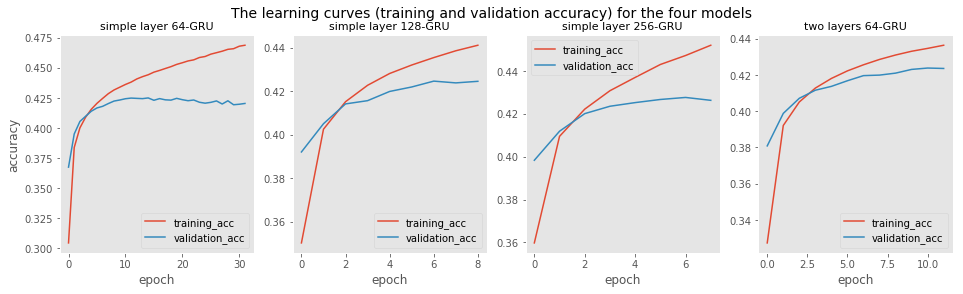

In [149]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
fig.suptitle('The learning curves (training and validation accuracy) for the four models',size=14)

ax[0].set_title('simple layer 64-GRU',size=11)
ax[0].plot(GRUmodel_log['acc'], label = "training_acc")
ax[0].plot(GRUmodel_log['val_acc'], label = "validation_acc")
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()


ax[1].set_title('simple layer 128-GRU',size=11)
ax[1].plot(logs['GRU_128']['acc'], label = "training_acc")
ax[1].plot(logs['GRU_128']['val_acc'], label = "validation_acc")
ax[1].set_xlabel('epoch')
ax[1].legend()

ax[2].set_title('simple layer 256-GRU',size=11)
ax[2].plot(logs['GRU_256']['acc'], label = "training_acc")
ax[2].plot(logs['GRU_256']['val_acc'], label = "validation_acc")
ax[2].set_xlabel('epoch')
ax[2].legend()

ax[3].set_title('two layers 64-GRU',size=11)
ax[3].plot(logs['GRU_2_64']['acc'], label = "training_acc")
ax[3].plot(logs['GRU_2_64']['val_acc'], label = "validation_acc")
ax[3].set_xlabel('epoch')
ax[3].legend()

plt.show();

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer** The different models early stops at different epoches with similar accuracy, because the convergence rate is different among the different models.

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer** EarlyStopping stopped the training process. The advantage is getting rid of the overfitting and the draw back is the inefficient training (probably stuck at local minimum).

**Question** What is your best model? Why? [1 pt]

**Answer** From the aspect of validation accuracy, the best model is the simple layer GRU with 256 neurons. It can reach the relative highest validation accuracy within fewest epoches. However, from the aspect of overfitting, the gap between train accuracy and test accuracy in double layers GRU is the smallest.

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer**

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer**

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer**

In [2]:
#load
import pickle
with open("data.pkl", "rb") as file:
    [sen_after_filter, sent_indseq, sent_padded, tokens] = pickle.load(file)

In [26]:
embedding_size = 128
hidden_size = 64
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    GRUmodel_log = pickle.load(file)
GRUmodel = load_model("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

In [12]:
def sample(preds, temperature):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [24]:
def predictRandomSentence(model, temperature):
    # initialize
    maxlen=23
    sent_init = [tokens.index('START')] + [tokens.index('PADD') for _ in range(21)]
    sent_init = np.array(sent_init)
    sent_init = sent_init.reshape((1,-1))
    sent_ret = []
    prob_record = np.zeros((len(tokens),maxlen-1))
    for i in range(maxlen-1):
        probs = model.predict_on_batch(sent_init)
        prob_record[:,i] = probs[0,i,:]
        step = sample(probs[0,i,:], temperature)
        if tokens[step] == 'END':
            break
        sent_ret.append(tokens[step])
        if i == maxlen-2:
            break
        sent_init[0,i+1] = step
    return ' '.join(sent_ret), prob_record

In [6]:
def plotProbSen(sent, prob_matrix):
    sent_token = sent.split(' ')
    sent_token_ind = [tokens.index(tok) for tok in sent_token]
    prob_matrix = prob_matrix[[sent_token_ind]]
    return prob_matrix

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

In [22]:
temps =  [0., 0.25, 0.5, 0.75, 1., 1.5, 2.]

In [30]:
sents_list = []
for temperature in temps:
    current_list = []
    for j in range(10):
        sent_generate, prob_matrix = predictRandomSentence(GRUmodel, temperature)
        current_list.append(sent_generate)
    sents_list.append(current_list)

In [35]:
for (tp, sents) in zip(temps, sents_list):
    print('+++++++++++++++++++ Temperature: %.2f +++++++++++++++++++++' % tp)
    for sent in sents:
        print(sent)

+++++++++++++++++++ Temperature: 0.00 +++++++++++++++++++++
i am doing well . how about yourself ?
i am doing well . how about yourself ?
i am doing well . how about yourself ?
i am doing well . how about yourself ?
i am doing well . how about yourself ?
i am doing well . how about yourself ?
i am doing well . how about yourself ?
i am doing well . how about yourself ?
i am doing well . how about yourself ?
i am doing well . how about yourself ?
+++++++++++++++++++ Temperature: 0.25 +++++++++++++++++++++
i am good . i just got home from work .
i am doing well , how about yourself ?
i have a dog . i have a dog .
i am doing well . how are you ?
i am doing well . how about yourself ?
i am doing well , how are you ?
i am doing well . just got home from work . how are you ?
i am doing well , just got off work . how are you ?
i am good . how are you ?
i am doing well . how about yourself ?
+++++++++++++++++++ Temperature: 0.50 +++++++++++++++++++++
i am doing well and you ?
i am doing well .

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


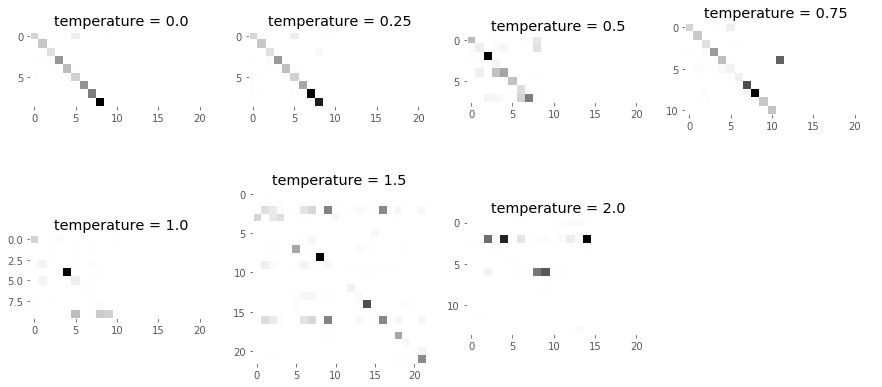

In [66]:
import math
fig,ax = plt.subplots(2,4,figsize=(15,7))
for (i,temperature) in enumerate(temps):
    sent_generate, prob_matrix = predictRandomSentence(GRUmodel, temperature)
    probs = plotProbSen(sent_generate, prob_matrix)
    ax[math.floor(i/4)][i-math.floor(i/4)*4].imshow(probs, cmap='Greys')
    ax[math.floor(i/4)][i-math.floor(i/4)*4].set_title('temperature = {}'.format(temperature))
    
ax[1][3].axis('off')
plt.show()

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

In [157]:
def predictRandomSentenceWithSeed(model, temperature, inputStart):
    # find the start words first
    maxlen=23
    try:
        inputIndex = [tokens.index(w) for w in inputStart]
    except:
        print('The tokens doesnot contain the word')
        return
    sent_init = [tokens.index('START')] + inputIndex + [tokens.index('PADD') for _ in range(21-len(inputIndex))]
    sent_init = np.array(sent_init)
    sent_init = sent_init.reshape((1,-1))
    sent_ret = inputStart
#     prob_record = np.zeros((len(tokens),maxlen-1))
    for i in range(maxlen-1-len(inputIndex)):
        probs = model.predict_on_batch(sent_init)
#         print(probs.shape)
        step = sample(probs[0,i+len(inputIndex),:], temperature)
        if tokens[step] == 'END':
            break
        sent_ret.append(tokens[step])
        if i == maxlen-2-len(inputIndex):
            break
        sent_init[0,i+1] = step
    return ' '.join(sent_ret)

In [178]:
sentTest1 = 'i am eating'

In [179]:
for i in range(10):
    print(predictRandomSentenceWithSeed(GRUmodel, 1, sentTest1.split()))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


i am eating so dinner ice cream can be the holidays also that is what i know to
i am eating pizza fresh fries going sitting in the city is so true
i am eating pizza my mac and cheese pizza and tacos . lol
i am eating pizza chocolate tuna ! what do you do for fun ?
i am eating through mostly shrimp . dogs make everyday , though . lol i am quite excellent on the water !
i am eating my pizza dinner the cold is my favorite color . my class is new .
i am eating a i sea bike is my favorite color currently
i am eating out mac boss , in my spare time .
i am eating
i am eating it some game of thrones i like i have fun


In [169]:
sentTest2 = 'how are you'

In [170]:
for i in range(10):
    print(predictRandomSentenceWithSeed(GRUmodel, 1, sentTest2.split()))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


how are you doing ? like video games ?
how are you doing read like music . and you ?
how are you today from , i am doing ok at everything right now
how are you doing sure will look for it in a talent luck . . .
how are you doing really into sports . how long is it a little bit for longer job ?
how are you doing like
how are you ? in its , they listen sweet in my bit of town .
how are you , 10 are a year and i help me out running .
how are you doing really like alot of that job .
how are you doing ? as much as role playing


**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer** Sampling temperature controls the randomness of sampling process. With temperature, the logits will be mapped into softmax function. A higher temperature will flatten the probality, letting the words with lower logits be more likely to be selected.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer** The word with the maximum probability is sampled, which is also called 'Greedy sampling'. 

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer** The word is sampled according to the weight of softmax probability, which is also called 'Random sampling'.

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** Higher sampling temperature corresponds to the more random sampling process.

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer** Each word is sampled according to the softmax probability vector generated from the model with the effect of sampling temperature. Started with the empty sentences started with 'START', we feed it into our network to get the probability matrix. We sample the first word with temperature based on the first row of the matrix. Repeatedly operate it until 'END' or reaching the max length.

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer** Yes, these probable words relate the synonyms in terms of language.

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer**

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

In [131]:
embedded_matrix = GRUmodel.get_layer('embedding').get_weights()

In [132]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(embedded_matrix[0])

/home/lijunze0627/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [133]:
X_embedded

array([[ 0.8180478,  1.1909264],
       [-1.3354055, -5.0075493],
       [ 0.6750792,  6.507909 ],
       ...,
       [ 0.9934255,  3.1631854],
       [ 4.979938 ,  1.2309028],
       [-5.0862827,  4.7011957]], dtype=float32)

In [134]:
X_embedded.shape

(1646, 2)

In [135]:
words = [w for sen in sen_after_filter for w in sen.split(' ')]

In [136]:
from collections import Counter
wfreq = Counter(words)

In [137]:
wfreq_top200 = sorted(wfreq.items(), key=lambda x: x[1], reverse=True)[:200]

In [138]:
words_top200 = [w[0] for w in wfreq_top200]

In [139]:
words_top200_ind = [tokens.index(w) for w in words_top200]
vectors_top200 = X_embedded[words_top200_ind]

In [140]:
np.shape(vectors_top200)

(200, 2)

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

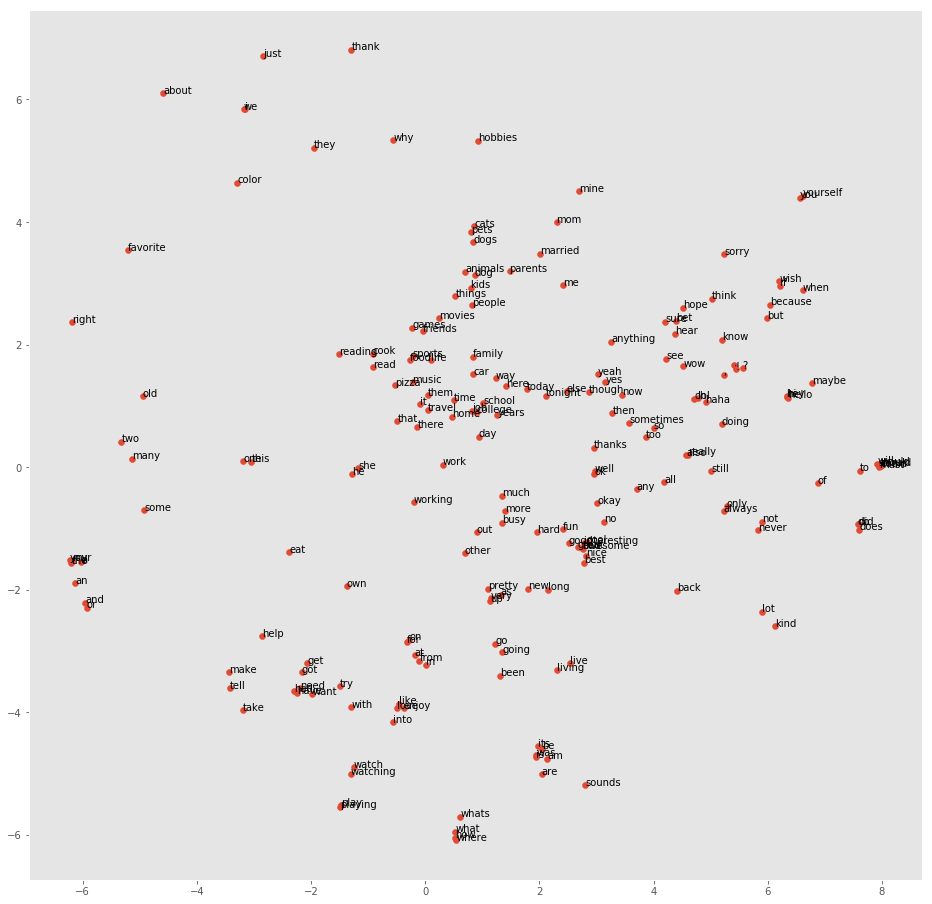

In [141]:
fig, ax = plt.subplots(figsize=(16,16))
ax.scatter(vectors_top200[:,0], vectors_top200[:, 1])

for i in range(200):
    ax.annotate(words_top200[i], (vectors_top200[i,0], vectors_top200[i,1]))

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer** Yes, for example 'whats, what, where','am, is, are' and 'cats, pets, dogs'. 

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer** Because word vectors are high-dimensionality which results in the sparsity in the vector space, we can use word embedding to represent the word vectors in a low dimension space to detect the clusters of the similar words.

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer**

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

In [10]:
# get the training data
training_diag = getRawDataFromFile(datapath='personachat/', file="train_both_revised.txt")

In [11]:
def generateDiag(diags):
    # transfer diags to pairs
    diag_pair = [[conv[i], conv[i+1]] for conv in diags for i in range(len(conv)-1)]
    
    def cleanDiag(diags):
        diag_w = list(set([w for diag in diags for w in diag.split(' ')]))
        for w in diag_w:
            if w not in tokens:
                return False
        return True
    
    diag_pair_filtered = list(filter(cleanDiag, diag_pair))
    return diag_pair, diag_pair_filtered    

In [12]:
diag_pair, diag_pair_filter = generateDiag(training_diag)
print('The number of diags before filter is {}'.format(len(diag_pair)))
print('The number of diags after filter is {}'.format(len(diag_pair_filter)))

The number of diags before filter is 122486
The number of diags after filter is 33315


**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

In [13]:
# start, end, padding
diag_pair_start_end = [[conv[0].split(' '), ['START'] + conv[1].split(' ') + ['END']] for conv in diag_pair_filter]
diag_pair_start_end[0]

[['hi', ',', 'how', 'are', 'you', 'doing', 'today', '?'],
 ['START',
  'i',
  'am',
  'spending',
  'time',
  'with',
  'my',
  '4',
  'sisters',
  'what',
  'are',
  'you',
  'up',
  'to',
  'END']]

In [14]:
# transfer the sent token to integer
diag_pairint_no_pad = [[[tokens.index(w) for w in sent] for sent in conv] for conv in diag_pair_start_end]
diag_pairint_no_pad[0]

[[1201, 627, 1132, 319, 870, 108, 1107, 1063],
 [1644,
  714,
  994,
  1156,
  781,
  1012,
  502,
  135,
  1162,
  1471,
  319,
  870,
  382,
  723,
  1645]]

In [15]:
# add padding
maxlen=23
diag_pair_padding = [paddingAndTruncate(conv) for conv in diag_pairint_no_pad]
diag_pair_padding[0]

array([[1201,  627, 1132,  319,  870,  108, 1107, 1063,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [1644,  714,  994, 1156,  781, 1012,  502,  135, 1162, 1471,  319,
         870,  382,  723, 1645,    0,    0,    0,    0,    0,    0,    0,
           0]])

In [17]:
# questions and answers
from keras.utils import to_categorical
Q = [conv[0][:-2] for conv in diag_pair_padding]
AnsInput = np.array([conv[1][:-1] for conv in diag_pair_padding])
AnsOutput = [conv[1][1:] for conv in diag_pair_padding]
AVectorOutput = np.array([[to_categorical(w, num_classes=len(tokens)) for w in sent] for sent in AnsOutput])
Ques = np.array(Q)

In [18]:
print(Ques.shape, AnsInput.shape, AVectorOutput.shape)

(33315, 21) (33315, 22) (33315, 22, 1646)


In [120]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1
readout_size = 100

In [122]:
context = Input(shape=(maxlen-2,), name="input_context")
# shared_embedding = E['GRU']
shared_embedding = GRUmodel.get_layer('embedding')
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 22)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 21)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             210688      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  49408       embedding[1][0]                  
__________

**Code** Train your chatbot model on your dataset. [1 pt]

In [123]:
ChatRotLog = Chatbot.fit([Ques, AnsInput],[AVectorOutput],
                         epochs=epochs, 
                         validation_split=validation_split, 
                         batch_size=batch_size).history

Train on 26652 samples, validate on 6663 samples
Epoch 1/32
26652/26652 [==============================] - 91s 3ms/step - loss: 4.2578 - acc: 0.2613 - val_loss: 3.5457 - val_acc: 0.3436
Epoch 2/32
26652/26652 [==============================] - 86s 3ms/step - loss: 3.3713 - acc: 0.3590 - val_loss: 3.2675 - val_acc: 0.3693
Epoch 3/32
26652/26652 [==============================] - 85s 3ms/step - loss: 3.1677 - acc: 0.3785 - val_loss: 3.1525 - val_acc: 0.3816
Epoch 4/32
26652/26652 [==============================] - 86s 3ms/step - loss: 3.0566 - acc: 0.3885 - val_loss: 3.0804 - val_acc: 0.3904
Epoch 5/32
26652/26652 [==============================] - 88s 3ms/step - loss: 2.9770 - acc: 0.3963 - val_loss: 3.0320 - val_acc: 0.3931
Epoch 6/32
26652/26652 [==============================] - 86s 3ms/step - loss: 2.9160 - acc: 0.4021 - val_loss: 2.9961 - val_acc: 0.3984
Epoch 7/32
26652/26652 [==============================] - 84s 3ms/step - loss: 2.8622 - acc: 0.4079 - val_loss: 2.9716 - val_acc:

In [124]:
#save
with open("Chatbot"+"_log.pkl", "wb") as file:
    pickle.dump(ChatRotLog, file)
Chatbot.save("Chatbot")

/home/lijunze0627/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer decoder was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder/while/Exit_3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'encoder/while/Exit_4:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [2]:
Chatbot = load_model('Chatbot')

### Question test

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

In [4]:
def predictAnswer(q, model, temp):
    # low performce run encode repeatedly
    ans = np.array([[tokens.index('START')] + [tokens.index('PADD') for _ in range(maxlen-2)]])
    q_ind = np.array([[tokens.index(w) for w in q.split(' ')]])
    # padding
    q_input = paddingAndTruncate(q_ind)[:, :-2]
#     print(q_input.shape)
    ans_ret = []
    
    for i in range(maxlen-1):
        preds = model.predict([q_input, ans])[0]
        word_ind = sample(preds=preds[i], temperature=temp)
        if tokens[word_ind] == 'END' or i == maxlen-2:
            break
        ans_ret.append(tokens[word_ind])
        ans[0, i+1] = word_ind
    return ' '.join(ans_ret)

In [16]:
select_list = np.random.randint(0,len(diag_pair_filter),10)

In [17]:
real_gene_ans_0_5 = []
real_gene_ans_1 = []
for i in select_list:
    real_gene_ans_0_5.append([diag_pair_filter[i][0], diag_pair_filter[i][1], predictAnswer(diag_pair_filter[i][0], Chatbot, 0.5)])
    real_gene_ans_1.append([diag_pair_filter[i][0], diag_pair_filter[i][1], predictAnswer(diag_pair_filter[i][0], Chatbot, 1)])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [32]:
print('Temperature = 0.5')
cnt = 1
for sents in real_gene_ans_0_5:
    print('====================== Comparison %d ===================='%cnt)
    cnt += 1
    print('Question: ' + sents[0])
    print('Real Answer' + sents[1])
    print('Predicted Answer' + sents[2])

Temperature = 0.5
====================== Comparison 1 ====================
Question: agreed . old school music is the best .
Real Answermy favorite is classical , how about you ?
Predicted Answeri love to eat too , i love it
====================== Comparison 2 ====================
Question: yes it is , i love it .
Real Answerwhat is it about ? i have not heard of it .
Predicted Answeryeah that is a great thing to do
====================== Comparison 3 ====================
Question: what kind of animals ?
Real Answerall animals ! i love animals . do you have any hobbies ?
Predicted Answeri listen to classical music while i am a little bit of fishing .
====================== Comparison 4 ====================
Question: i was hoping you would say that . i want to exercise more
Real Answeri need to do that also . i live in texas .
Predicted Answeri will never just got to know what you say .
====================== Comparison 5 ====================
Question: yes it is for my sister
Real Answe

In [33]:
print('Temperature = 1')
cnt = 1
for sents in real_gene_ans_1:
    print('====================== Comparison %d ===================='%cnt)
    cnt += 1
    print('Question: ' + sents[0])
    print('Real Answer' + sents[1])
    print('Predicted Answer' + sents[2])

Temperature = 1
====================== Comparison 1 ====================
Question: agreed . old school music is the best .
Real Answermy favorite is classical , how about you ?
Predicted Answerhe too . do you get out much much vegetarian while like doing today
====================== Comparison 2 ====================
Question: yes it is , i love it .
Real Answerwhat is it about ? i have not heard of it .
Predicted Answerwhat kind of music do you like
====================== Comparison 3 ====================
Question: what kind of animals ?
Real Answerall animals ! i love animals . do you have any hobbies ?
Predicted Answerpink , do you like to cook
====================== Comparison 4 ====================
Question: i was hoping you would say that . i want to exercise more
Real Answeri need to do that also . i live in texas .
Predicted Answeryou should take healthy space p
====================== Comparison 5 ====================
Question: yes it is for my sister
Real Answerwhat do you do f

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer** Sampling temperature equals to 0.5 gives better answer, because the generated answers are more similar to the real answers.

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer** No, the reproduced answers maybe overfit to the real answers.

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]

#### Play with trained Chatbot

In [13]:
import warnings
warnings.filterwarnings("ignore")
num_conv = 20
sent1 = 'how are you'
print('Bot1: ', sent1)
for i in range(num_conv):
    sent2 = predictAnswer(sent1, Chatbot, 1)
    sent1 = predictAnswer(sent1, Chatbot, 1)
    print('Bot2: ', sent2)
    print('Bot1: ', sent1)

Bot1:  how are you
Bot2:  already too bad how about you ?
Bot1:  i am working on a couch
Bot2:  so what is that you do in your wedding ?
Bot1:  now but i am super fat and i love doing it
Bot2:  happy job is important . my parents are red boots .
Bot1:  ah , that is fun . i wish i could play in my spare time
Bot2:  i think i would to be a musical life .
Bot1:  maybe we will ! . the wife was never way lost healthy
Bot2:  that must keep up if i will check there some pizza !
Bot1:  no , can not one and it , we go skiing too ! we got also cool to read .
Bot2:  reading is my favorite music . hows that i cook ?
Bot1:  i love to read . a car i might have to be a good partner . for sales too walk .
Bot2:  that means no idea .
Bot1:  the siblings are you male or female ?
Bot2:  i am a female , how about yourself ?
Bot1:  i am a female . love black , how about you
Bot2:  i am a student . three dogs . where do you ?
Bot1:  i like pizza , i often read everything stories to eat and shopping .
Bot2: 

---